<i><b>Public AI</b></i>

# Regularization (2) Dropout

### _Objective_
* 딥러닝에서 많이 이용하는 정규화 방법 중 하나인 Dropout에 대해 배워보도록 하겠습니다. <br>
  

In [1]:
%matplotlib inline
import os
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

np.random.seed(30)
tf.random.set_seed(30)

## 예제 데이터 ) 기술투자 비율과 예상 수익률 데이터 셋

기술 투자 비율과 예상 수익률에 대한 데이터셋입니다. <br>
아래와 같이 랜덤으로 50개의 데이터셋을 만들고, Test 데이터셋은 노이즈를 주지 않았습니다.<br>
데이터에 노이즈가 많고, 수가 적을 때 일반적으로 Overfitting이 발생하기 쉽습니다.

In [32]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

train_invests = np.random.uniform(0.05,0.9, 50)
train_growths = np.array([random_polynomial(x)+np.random.normal(0,0.02) 
           for x in train_invests]) # 예상 수익률

train_invests = train_invests.reshape(-1,1) 
train_growths = train_growths.reshape(-1,1) 

test_invests = np.linspace(0.05,0.9,30)
test_growths = np.array([random_polynomial(x)
                         for x in test_invests])

test_invests = test_invests.reshape(-1,1)
test_growths = test_growths.reshape(-1,1)

print("train 데이터셋 크기 : {}".format(len(train_invests)))
print("test 데이터셋 크기 : {}".format(len(test_invests)))

train 데이터셋 크기 : 50
test 데이터셋 크기 : 30


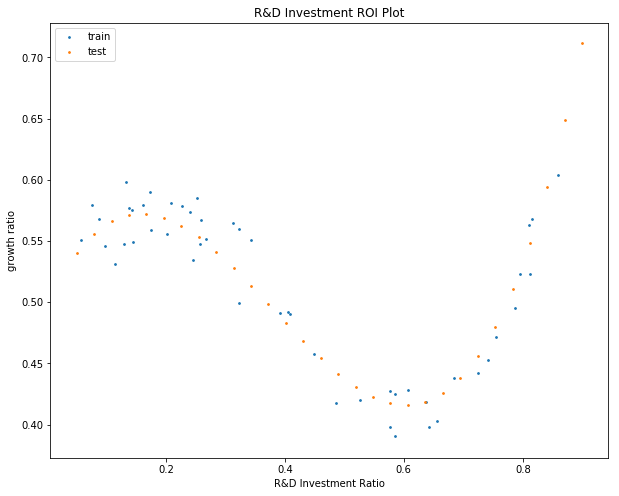

In [33]:
plt.figure(figsize=(10,8))
plt.scatter(train_invests, train_growths, s=3,label='train')
plt.scatter(test_invests, test_growths, s=3,label='test')
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.legend()
plt.show()

<br><br>

# \[ 1. 드랍아웃이란? \]

----


* 드랍아웃은 매우 간단한 아이디어로, 딥러닝 모델에 강력한 정규화 효과를 가져다 주는 알고리즘입니다.

## 1. 드랍아웃 알고리즘

![Imgur](https://i.imgur.com/m9diJOx.png)

드랍아웃 알고리즘은 매우 간단합니다. 매 훈련 스텝에서 각 유닛들은 p%확률로 꺼버리게 됩니다.<br>그리고 테스트를 하는 단계에서는 드롭아웃을 적용하지 않습니다.

<br>
## 2. 직접 Keras Layer를 구현하여 이해하기


* 놓치지 말아야할 것중 하나는 바로 훈련하는 동안에 각 뉴런의 출력을 보존 확률($1-p$)로 나누어야 합니다.<br>
* 이를 통해, Test 때의 입력값의 크기와 Train 때의 입력값의 크기가 비슷하도록 만들어 줍니다.<br>

### (1) dropout 레이어 구성하기 

In [72]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

In [74]:
class NaiveDropout(Layer):
    """
    직접 구현하기
    """
    def __init__(self, drop_ratio=0.5, **kwargs):
        self.drop_ratio = drop_ratio # 비율을 어떻게 
        super().__init__(**kwargs)
        
    def call(self, inputs, training=None):            
        if training:
            self.mask = K.random_binomial(tf.shape(inputs),
                                          1-self.drop_ratio)
            self.out = self.mask * inputs * (1.0/(1-self.drop_ratio))
        else:
            self.out = inputs
        return self.out

### (2) Test 때와 Train 때의 동작 비교

In [75]:
x = np.ones([10,124], np.float32)

In [76]:
train_phase_out = NaiveDropout(drop_ratio=0.6)(x, training=True)
train_phase_out

<tf.Tensor: id=362, shape=(10, 124), dtype=float32, numpy=
array([[0. , 0. , 2.5, ..., 0. , 0. , 2.5],
       [0. , 2.5, 2.5, ..., 0. , 2.5, 0. ],
       [2.5, 0. , 0. , ..., 2.5, 0. , 0. ],
       ...,
       [2.5, 2.5, 2.5, ..., 0. , 0. , 2.5],
       [2.5, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 2.5, 0. , ..., 0. , 0. , 0. ]], dtype=float32)>

In [77]:
test_phase_out = Dropout(drop_ratio=0.6)(x, training=False)
test_phase_out

<tf.Tensor: id=363, shape=(10, 124), dtype=float32, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>

<br>
## 3. Tensorflow에서의 동작 확인하기


### (1) Training 때의 동작 확인하기

In [78]:
from tensorflow.keras.layers import Dropout

In [79]:
x = tf.ones([10,124],tf. float32)

y = Dropout(rate=0.4)(x,training=True)
y

<tf.Tensor: id=379, shape=(10, 124), dtype=float32, numpy=
array([[0.       , 1.6666666, 1.6666666, ..., 1.6666666, 0.       ,
        1.6666666],
       [1.6666666, 1.6666666, 0.       , ..., 0.       , 1.6666666,
        0.       ],
       [1.6666666, 1.6666666, 1.6666666, ..., 1.6666666, 1.6666666,
        0.       ],
       ...,
       [0.       , 1.6666666, 1.6666666, ..., 0.       , 1.6666666,
        1.6666666],
       [1.6666666, 0.       , 1.6666666, ..., 0.       , 1.6666666,
        0.       ],
       [1.6666666, 1.6666666, 1.6666666, ..., 1.6666666, 1.6666666,
        0.       ]], dtype=float32)>

### (2) Test 때의 동작 확인하기

In [80]:
x = tf.ones([10,124],tf.float32)

y = Dropout(rate=0.4)(x,training=False)
y

<tf.Tensor: id=382, shape=(10, 124), dtype=float32, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>

<br><br>

# \[ 2. 드랍아웃 적용하기 \]

----

* 텐서플로우 내 Dropout을 이용하여 신경망에 적용해 보도록 하겠습니다.
* 드롭아웃을 적용할 수 있는 모형이나 훈련 절차에 별 제한이 없어, 사용성이 매우 좋습니다.

<br>
## 1. 드랍아웃을 포함한 그래프 구성하기

In [81]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.initializers import he_normal, glorot_normal

from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [82]:
num_hidden1 = 100 # 1번째 은닉층 unit 수
num_hidden2 = 100 # 2번째 은닉층 unit 수

x = Input((1,), name='x')
hidden1 = Dense(num_hidden1, 'relu', kernel_initializer=he_normal())(x)
hidden1 = Dropout(0.4)(hidden1)
hidden2 = Dense(num_hidden2, 'relu', kernel_initializer=he_normal())(hidden1)
hidden2 = Dropout(0.4)(hidden2)
y_pred = Dense(1, kernel_initializer=glorot_normal())(hidden2)
    
model = Model(x, y_pred)
    
model.compile(Adam(1e-2),
              loss=MeanSquaredError(),
              metrics=[RootMeanSquaredError()])

<br>
## 2. 모델학습시키기

* dropout은 train 상태일때와 test 상태일때 동작이 다릅니다. 이를 유의해서 사용해야 합니다.<br>

In [83]:
full_size = len(train_invests)
batch_size = 10

start_time = time.time()
history = model.fit(train_invests,
                    train_growths,
                    batch_size=batch_size,
                    epochs=28000*batch_size//full_size,
                    verbose=0)

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print("학습 총 소요 시간 ---- {:.3f}s".format(consumed_time))

학습 총 소요 시간 ---- 37.593s


## 3. 결과 확인하기

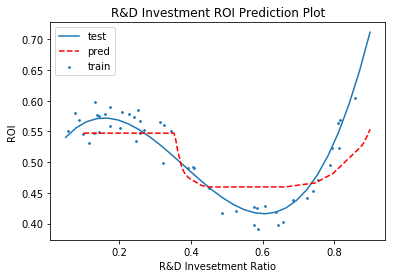

In [84]:
# 0부터 1까지 순서대로 1000개를 출력
test_xs = np.linspace(0.1,0.9,1000)
test_xs = test_xs.reshape(-1,1)
pred_ys = model.predict(test_xs)

plt.plot(test_invests, test_growths,label='test')
plt.plot(test_xs,pred_ys,'r--',label='pred')
plt.scatter(train_invests, train_growths, s=3, label='train')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()

<br>

## 4. Dropout의 기술적 특징

1. Dropout은 일종의 앙상블 기법으로 설명하기도 합니다.<br>
    앙상블이란, 복수 개의 모델을 같이 이용해 결과를 계산하는 기법을 통칭합니다.<br>
    Dropout은 일부 뉴런들을 꺼줌으로써, 부분 신경망(SubNetwork)를 구성하는 효과를 가집니다.<br>
    
2. Dropout은 한 유닛이 특정 input에만 의존하지 못하도록 만듭니다.<br>
   모든 input 유닛 값에 주의를 기울이게 되므로, 입력 값의 작은 변화에 덜 민감해집니다.

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/05

---